In [8]:
import numpy as np
import cv2
import sklearn
import scipy
import imageio
import math
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, minimize_scalar, root_scalar
import glob

In [66]:
def extract_num(fp):
    return int(fp.split('.')[0].split(' ')[1])

# read in the images
row0_files = sorted(glob.glob("test_data_6/0*"), key=extract_num)
row1_files = sorted(glob.glob("test_data_6/1*"), key=extract_num)


# row0 is horizontal, and row1 is above the horizontal 
row0, row1 = [cv2.imread(i) for i in row0_files], [cv2.imread(i) for i in row1_files]

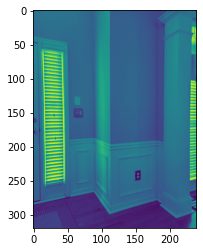

((112.10950987353168, 87.12577378650296), 0.04756825025789214)


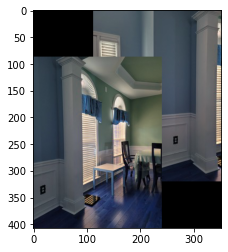

In [65]:
for i in [7]:
    plt.imshow(rgb2gray(row0[i]))
    plt.show()
    offset = cv2.phaseCorrelate(rgb2gray(row0[i]), rgb2gray(row0[i+1]))
    print(offset)

plt.imshow(combine_images(row0[i], row0[i+1], offset[0][0],offset[0][1]))

# Calculate $f$

In [81]:
# find the offsets for the horizontal images
def get_phase_correlations(images):
    offsets = []
    for i in range(len(images)-1):
        d = cv2.phaseCorrelate(images[i], images[i+1])
        offsets.append(d)
    return offsets

row0_offsets = get_phase_correlations([rgb2gray(img) for img in row0])

In [82]:
def combine_images(image1, image2, offset_x, offset_y):
    offset_x = -int(offset_x)
    offset_y = int(offset_y)
    if offset_x < 0:
        merge_width = max(image2.shape[1], image1.shape[1]-offset_x)
        warp_offset_x = 0
        ref_offset_x = offset_x
    else:
        merge_width = max(image2.shape[1] + offset_x, image1.shape[1])
        warp_offset_x = offset_x
        ref_offset_x = 0
    if offset_y < 0:
        merge_height = max(image2.shape[0], image1.shape[0]-offset_y)
        warp_offset_y = 0
        ref_offset_y = offset_y
    else:
        merge_height = max(image2.shape[0] + offset_y, image1.shape[0])
        warp_offset_y = offset_y
        ref_offset_y = 0
    
    combined_image = np.zeros((merge_height,merge_width,3)).astype(np.uint8)
    for y in range(image2.shape[0]):
        for x in range(image2.shape[1]):
            combined_image[y+warp_offset_y,x+warp_offset_x] = image2[y,x]
    
    for y in range(image1.shape[0]):
        for x in range(image1.shape[1]):
            if np.all((combined_image[y-ref_offset_y,x-ref_offset_x] == 0)):
                combined_image[y-ref_offset_y, x-ref_offset_x] = image1[y,x]
    return combined_image

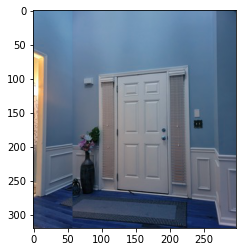

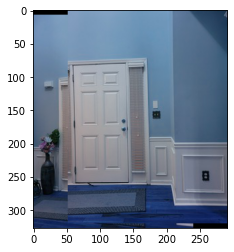

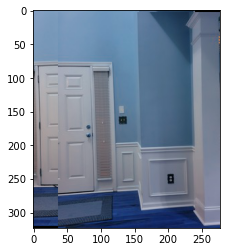

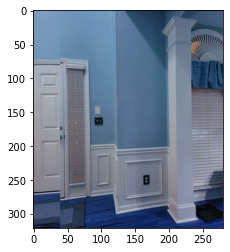

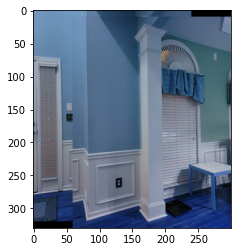

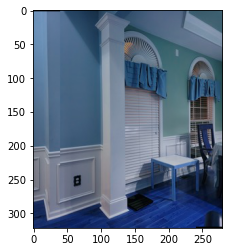

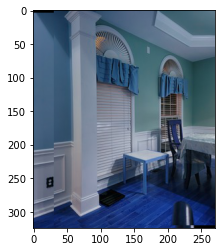

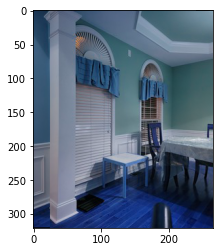

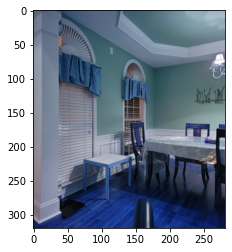

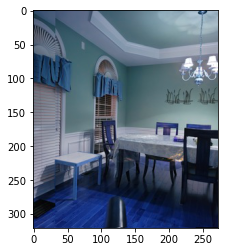

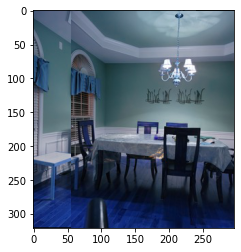

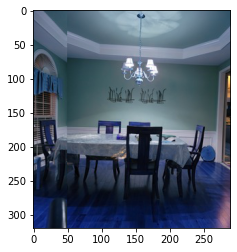

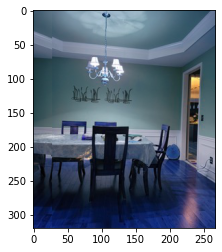

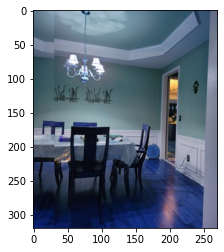

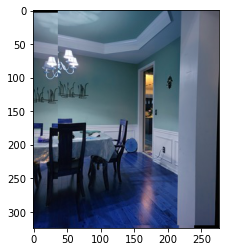

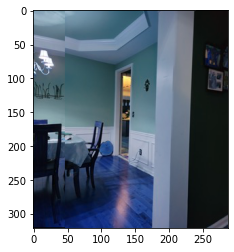

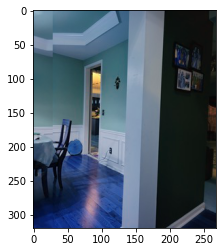

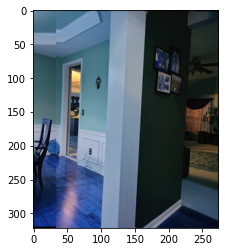

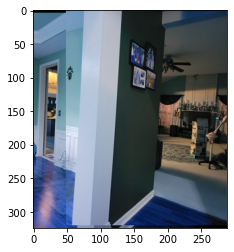

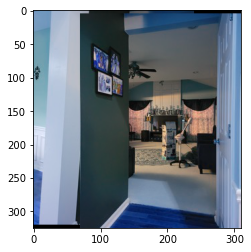

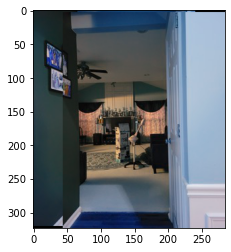

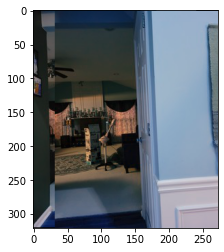

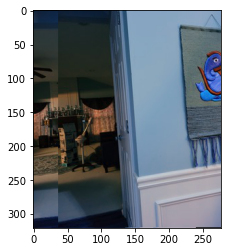

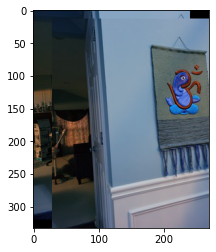

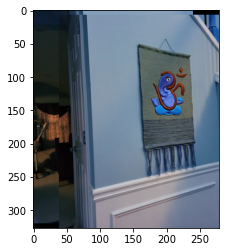

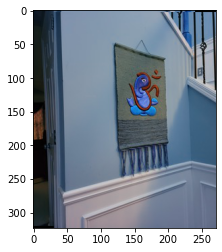

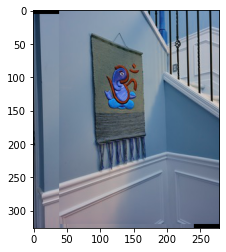

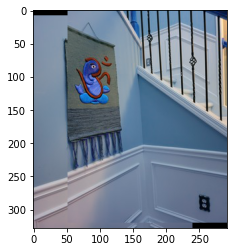

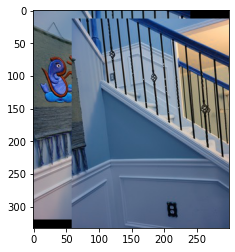

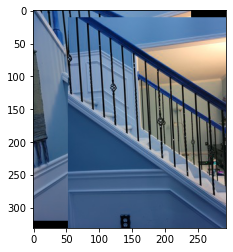

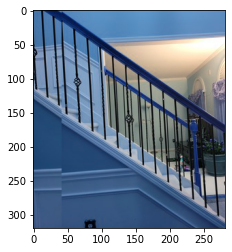

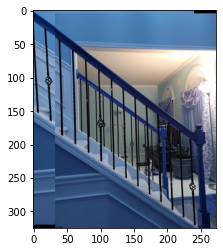

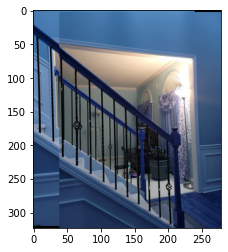

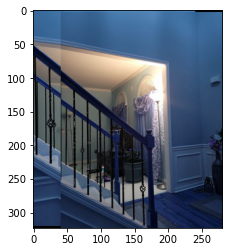

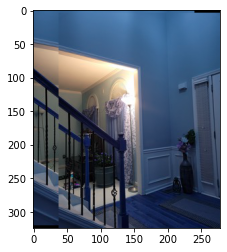

In [85]:
for i in range(len(row0_offsets)):
    x, y = row0_offsets[i][0]
    plt.imshow(combine_images(row0[i], row0[i+1],x, y))
    plt.show()

In [79]:
# calculate f: 2pi - 2 * sum(atan(d_i /f)) = 0
row0_offset_x = [x[0][0] for x in row0_offsets]
row0_offset_x = -np.array(row0_offset_x)

def cost(f):
    goal = 2*np.pi
    val = 2*np.arctan(row0_offset_x / f).sum()
    return val - goal

def costprime(f):
    # derivative of cost
    return (row0_offset_x / (row0_offset_x ** 2 + f ** 2)).sum()

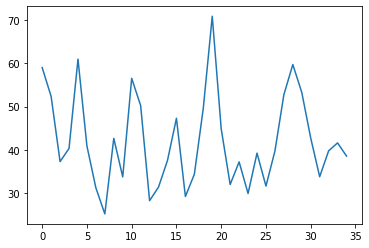

In [80]:
plt.plot(row0_offset_x)

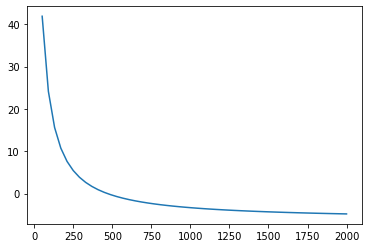

In [93]:
x = np.linspace(50, 2e3)
y = [cost(i) for i in x]
plt.plot(x, y)

In [98]:
res = root_scalar(cost, bracket=(250, 750), fprime=costprime)
f = res.root
print(f)

468.4060352058686


In [38]:
# recursively compute rotation angles of horizontal images


      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 66.99952550113566

In [2]:
def horizontalAngle(horizontal_shifts, focal_length):
    thetas = [None * len(horizontal_shifts)]
    thetas[0] = 0 
    for i in range(1, len(horizontal_shifts)):
        thetas[i] = thetas[i-1] + 2*np.arctan(thetas[i] / (2*f))
    return thetas

In [3]:
def verticalAngle(vertical_shifts, focal_length):
    gammas = [None * len(vertical_shifts)]
    gammas[0] = 0 
    for i in range(1, len(horizontal_shifts)):
        thetas[i] = thetas[i-1] + 2*np.arctan(thetas[i] / (2*f))
    return thetas